In [1]:
from math import pi, sqrt
from typing import Callable, Literal, Optional, Union

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerProvider
from qiskit_ibm_runtime import Session

# 6 - Sessions and Parameters

## Exercise 1

Define a function that allows to make executions in a session. It must reproduce the behaviour of a VQA algorithm, where a certain condition it is setted and it keeps iterating till accomplishing it. The input parameters must be:

   * A string noting if the execution should be based in the used of Sampler or Estimator primitives.
   * The quantum circuit to employ, with the correspondant parameterized gates.
   * Any other necessary input (ex: observable for the Estimator case, initial parameterized gate value...

Primero de todo, reciclamos la función `run_circuit` del notebook anterior, ya que nos simplificará el código.

In [2]:
def run_circuit(
    qc: Union[QuantumCircuit, list[QuantumCircuit]],
    executor: Literal["sampler", "estimator"],
    observable: Optional[SparsePauliOp] = None,
):
    if not isinstance(qc, list):
        circuits = [qc]
    else:
        circuits = qc

    if executor == "sampler":
        qc_with_measures = []
        for circuit in circuits:
            qc_with_measure = circuit.copy()
            qc_with_measure.measure_all()
            qc_with_measures.append(qc_with_measure)

        sampler = StatevectorSampler()
        job = sampler.run(qc_with_measures)
        result = job.result()
        return result

    elif executor == "estimator":
        jobs_to_run = []
        for circuit in circuits:
            if observable is None:
                obs = SparsePauliOp("Z" * circuit.num_qubits)
            else:
                obs = observable

            jobs_to_run.append((circuit, obs))

        estimator = StatevectorEstimator()
        job = estimator.run(jobs_to_run)
        result = job.result()
        return result

    else:
        raise ValueError("Invalid executor type. Must be 'sampler' or 'estimator'.")

Definimos ahora la función `execute_in_session` que pide el enunciado, tomando los siguientes argumentos:

- `executor`: si se desea ejecutar con `sampler` o `estimator`.
- `qc`: circuito a ejecutar.
- `theta_param`: parámetro que toma el circuito.
- `initial_param_value`: valor inicial que toma el parámetro.
- `condition`: condición que se debe cumplir para terminar el bucle.
- `modify_theta`: cómo se debe de modificar el valor del parámetro en cada iteración hasta que se cumpla la condición.
- `observable`: observable para el `estimator`.

In [3]:
def execute_in_session(
    executor: Literal["sampler", "estimator"],
    qc: QuantumCircuit,
    theta_param: Parameter,
    initial_param_value: float,
    condition: Callable[[any], bool],
    modify_theta: Callable[[float], float],
    observable: Optional[SparsePauliOp] = None,
):
    backend = AerProvider().get_backend("aer_simulator")

    theta_val = initial_param_value

    with Session(backend=backend):
        while True:
            # 1. En cada iteración, "fijamos" el parámetro a un valor numérico
            bound_qc = qc.assign_parameters({theta_param: theta_val})

            # 2. Reutilizamos tu función del ejercicio anterior
            result = run_circuit(bound_qc, executor, observable)

            # 3. Comprobamos la condición de parada
            if condition(result):
                break

            # 4. Actualizamos el valor del parámetro para la siguiente iteración
            theta_val = modify_theta(theta_val)

    return theta_val, result

### Probar la función

Probemos ahora esta función tanto con `sampler` como con `executor`.

Primero definimos el siguiente circuito:


#### `Sampler`

Definimos un circuito:

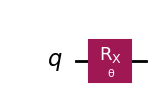

In [4]:
theta = Parameter("θ")
qc = QuantumCircuit(1)
qc.rx(theta, 0)
qc.draw(output="mpl")

Definimos los callbacks:

In [5]:
def condition_sampler(result):
    counts = result[0].data.meas.get_counts()
    shots = sum(counts.values())
    p1 = counts.get("1", 0) / shots
    print(" > P(1) = " + str(p1))
    return p1 > 0.5


def modify_theta_sampler(theta_val: float) -> float:
    return theta_val + pi / 8¶

Ejecutamos el circuito:

In [6]:
theta_final, last_result = execute_in_session(
    executor="sampler",
    qc=qc,
    theta_param=theta,
    initial_param_value=pi / 8,
    condition=condition_sampler,
    modify_theta=modify_theta_sampler,
)

print("Theta final: " + str(theta_final))
print("Last counts:", last_result[0].data.meas.get_counts())

 > P(1) = 0.0458984375
 > P(1) = 0.15625
 > P(1) = 0.3017578125
 > P(1) = 0.4931640625
 > P(1) = 0.67578125
Theta final: 1.9634954084936207
Last counts: {'1': 692, '0': 332}


#### `Estimator`

Definimos un circuito:

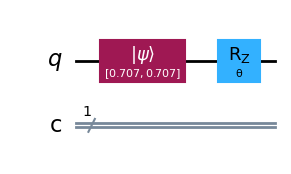

In [7]:
theta = Parameter("θ")
qc = QuantumCircuit(1, 1)
qc.initialize([1 / sqrt(2), 1 / sqrt(2)], 0)
qc.rz(theta, 0)
qc.draw(output="mpl")

Definimos los callbacks:

In [8]:
def condition_estimator(result):
    ev = result[0].data.evs.item()
    print(" > Expected Value = " + str(ev))
    return ev > 0.5


def modify_theta_estimator(theta_val: float) -> float:
    return theta_val + pi / 16

Ejecutamos el circuito:

In [9]:
theta_final, last_result = execute_in_session(
    executor="estimator",
    qc=qc,
    theta_param=theta,
    initial_param_value=-pi / 8,
    condition=condition_estimator,
    modify_theta=modify_theta_estimator,
    observable=SparsePauliOp("Y"),
)

final_ev = last_result[0].data.evs.item()
print(f"Theta final: {theta_final:.3f}")
print(f"Expectation value final: {final_ev:.3f}")

 > Expected Value = -0.3826834323650896
 > Expected Value = -0.19509032201612825
 > Expected Value = 0.0
 > Expected Value = 0.19509032201612825
 > Expected Value = 0.3826834323650896
 > Expected Value = 0.555570233019602
Theta final: 0.589
Expectation value final: 0.556
